<a href="https://colab.research.google.com/github/solobala/STPY36/blob/main/STPY36_DZ7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание "Дисперсионный анализ и виды ошибок. А/В - тесты"

## Импорт библиотек

In [ ]:
#  Numpy, Pandas
import pandas as pd
import numpy as np
from numpy import random
from math import ceil

#  Статистика
import scipy as sp
#from scipy.stats import shapiro
from scipy import stats as st
from scipy.stats import t
from scipy.stats import f_oneway
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.stats.api as sms
#  Графика
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from IPython.display import Image

## Вспомогательные функции

Много полезных библиотек https://github.com/capissimo/python-for-data-science/blob/master/ch02_Inference.ipynb

In [ ]:
def fisher_test(data):
    print('Нулевая гипотеза:', '='.join(data))
    print('Альтернативная гипотеза:', f'!({"=".join(data)})')
    grand_mean =data.values[~np. isnan (data)].flatten().mean() 
    sst = sum((val - grand_mean)**2 for val in data.values[~np. isnan (data)].flatten())
    ssb = sum(data[data[group].notna()][group].size * (group_mean - grand_mean) ** 2 for group, group_mean in data.mean().items())
    ssw = sum(sum((x - group_mean)**2 for x in data[data[group].notna()][group]) for group, group_mean in data.mean().items())
    groups = data.shape[1]
    dfb = groups - 1
    dfw =len(data.values[~np. isnan (data)].flatten()) - groups
    mssb = ssb/dfb
    mssw = ssw/dfw
    f_value = mssb/mssw
    p = st.f.sf(f_value, dfb, dfw) #sf - Survival function - что это такое? Это оценка вероятности наступления события
    print('Результат:')
    if p < 0.05:
        print('отклоняем нулевую гипотезу')
    else:
        print('Не отклоняем нулевую гипотезу')
    print(f"p_value = {p},  f-значение = {f_value}")

## Загрузка датасетов

In [ ]:
!wget -O "АБ_тестирование.zip" "https://u.netology.ru/backend/uploads/lms/attachments/files/data/35264/АБ_тестирование.zip"   # Качаем архив выбранного датасета в сессионное хранилище

--2022-11-04 19:05:03--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/35264/%D0%90%D0%91_%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.zip
Resolving u.netology.ru (u.netology.ru)... 92.53.68.16, 2a00:ab00:610:1::1
Connecting to u.netology.ru (u.netology.ru)|92.53.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1298824 (1.2M) [application/x-zip-compressed]
Saving to: ‘АБ_тестирование.zip’

АБ_тестирование.zip 100%[===================>]   1.24M  1.28MB/s    in 1.0s    

2022-11-04 19:05:05 (1.28 MB/s) - ‘АБ_тестирование.zip’ saved [1298824/1298824]



In [ ]:
from zipfile import ZipFile  # Подключаем библиотеку ZipFile из пакета zipfile

In [ ]:
with ZipFile("АБ_тестирование.zip", 'r') as zip_file:  # Распаковываем архив в сессионное хранилище в папку ml-latest-small. Нам понадобятся файлы ratings.csv и movies.csv
     zip_file.extractall('/content/')
     #zip_file.extract('ml-latest-small/ratings.csv')

##  Дисперсионный анализ

### Немного теории

Рассмотренный ранее **t-критерий Стьюдента** (равно как и его непараметрические аналоги) предназначен для сравнения исключительно **двух совокупностей**. В таком случае мы можем применять однофакторный дисперсионный анализ.  Та переменная, которая будет разделять наших испытуемых или наблюдения на группы (номинативная переменная с нескольким градациями) называется **независимой переменной**. А та количественная переменная, по степени выраженности которой мы сравниваем группы, называется **зависимая переменная**. 


$$ SS_{total} = \sum_{j=1}^{p}{\sum_{i=1}^{n_j}{(x_{ij} - \bar{x})^2}} = SS_{between} + SS_{within} $$
$$ SS_{between} = \sum_{j=1}^{p}{n_j{(\bar{x}_j - \bar{x})^2}} $$
$$ SS_{within} = \sum_{j=1}^{p}{\sum_{i=1}^{n_j}{(x_{ij} - \bar{x}_j)^2}} $$


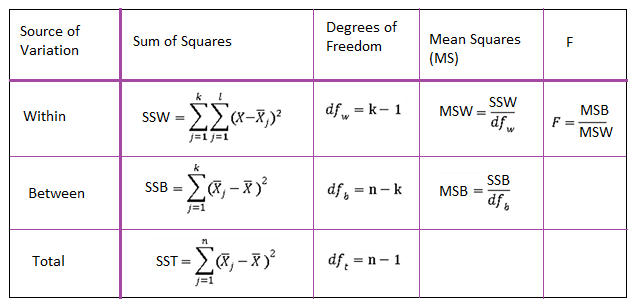

In [ ]:
Image("/content/АБ_тестирование/var_analysis.png")

In [ ]:
# Выборки которые надо сравнить
# Был словарь, ключи - название признака, значения - списки значений.
# Делаем из словаря датафрейм. Ключи - название столбцов, списки - содержимое столбцов
data =\
    pd.DataFrame({
        'a': [3, 1, 2],
        'b': [5, 3, 4],
        'c': [7, 6, 5]
    })
data.head()

,a,b,c
0,3,5,7
1,1,3,6
2,2,4,5


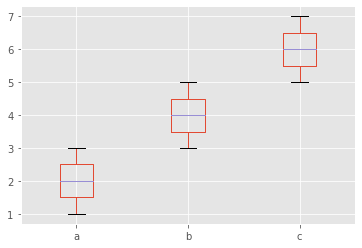

In [ ]:
data.boxplot() # Видно что у 3 колонок - разные средние. Это надо проверять с помощью тестов
# формулируем нулевую гипотезу о равенстве средних

In [ ]:
print('Нулевая гипотеза:', '='.join(data))
print('Альтернативная гипотеза:', f'!({"=".join(data)})')

Нулевая гипотеза: a=b=c
Альтернативная гипотеза: !(a=b=c)


In [ ]:
data.values # Получаем из датафрейма массив numpy ndarray с размерностью 3Х3

array([[3, 5, 7],
       [1, 3, 6],
       [2, 4, 5]])

In [ ]:
data.values.flatten()#(собираем все списки в 1  -  уменьшает размерность ndarray массива data до одномерного)

array([3, 5, 7, 1, 3, 6, 2, 4, 5])

In [ ]:
# И считаем общее среднее
grand_mean = data.values.flatten().mean()
grand_mean

4.0

In [ ]:
# сумма квадратов отклонений значений от общего среднего sst = ssb + ssw
sst = sum((val - grand_mean)**2 for val in data.values.flatten())
sst

30.0

In [ ]:
data.mean() # -групповые средние по каждой группе
type(data.mean()) #- тип -series. Это словарь, где ключи - значение индекса(a,b,c), значения - сами групповые средние (можно получить по индексу)
data.mean().keys()
data.mean()['a']
data.mean().items() #-zip_объект

In [ ]:
# отклонение групповых средних от общего среднего. Перебираем в цикле групповые средние
# Почему умножаем на размер группы data[group].size, все правильно
ssb = sum(data[group].size * (group_mean - grand_mean) ** 2 for group, group_mean in data.mean().items())

In [ ]:
# отклонения значений внутри группы от средней группы
ssw = sum(sum((x - group_mean)**2 for x in data[group]) for group, group_mean in data.mean().items())

In [ ]:
groups = data.shape[1]  # кол-во групп
data.shape[1]

3

In [ ]:
# Степени свободы
dfb = groups - 1 # для межгрупповой дисперсии
dfw = data.size - groups # а это что??
# межгрупповой средний квадрат - Это межгрупповая дисперсия?
mssb = ssb/dfb
# внутригрупповой средний квадрат - это внуригрупповая дисперсия?
mssw = ssw/dfw

f_value = mssb/mssw

p = st.f.sf(f_value, dfb, dfw) #sf - Survival function - что это такое? Это оценка вероятности наступления события
print('Результат:')
if p < 0.05:
    print('отклоняем нулевую гипотезу')
else:
    print('НЕ отклоняем нулевую гипотезу')
print(f"Полученное f-значение {f_value}")

Результат:
отклоняем нулевую гипотезу
Полученное f-значение 12.0


Посмотрим, на распределение в нашем случае
- https://gallery.shinyapps.io/dist_calc/ 



#### почему мы не можем применить t-критерий для более двух выборок
**применяя его попарно к каждой выбрке**

Чтобы выяснить это, сделаем эксперемент.

In [ ]:

def pair_t(samples, alpha):
    '''Парный t-критерий, если все выборки равны, возвращает True'''
    n_samples = samples.shape[0]
    # https://ru.wikipedia.org/wiki/Сочетание
    n_combinations = n_samples*(n_samples - 1)//2
    result = np.zeros(n_combinations, dtype=bool)
    k = 0
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            N = samples[i].size
            std_err = np.sqrt((samples[i].std()**2) /
                              N + (samples[j].std()**2)/N)
            t_value = (samples[i].mean() + samples[j].mean())/std_err
            p = t.sf(t_value, N-2)
            result[k] = p >= alpha
            k += 1
    return np.all(result)


def pair_t_test(repeat, n_samples, sample_size, ax, alpha=0.05):
    '''
    функция показывает, сколько у нас будет ложных результатов, при парном сравнение множества выборок
    с помощью t-критерия

    repeat - количество повторов
    n_samples - количество выборок в каждом повторе
    sample_size - размер выборки

    ax - для рисования
    alpha = (1 - (p-уровень значимости))
    '''
    result = np.zeros(repeat, dtype=bool)
    for i in range(repeat):
        samples = random.randn(n_samples, sample_size)
        result[i] = pair_t(samples, alpha)

    unique, counts = np.unique(result, return_counts=True)
    percentage = counts/result.size
    ax.pie(percentage, labels=unique, autopct='%.0f%%')

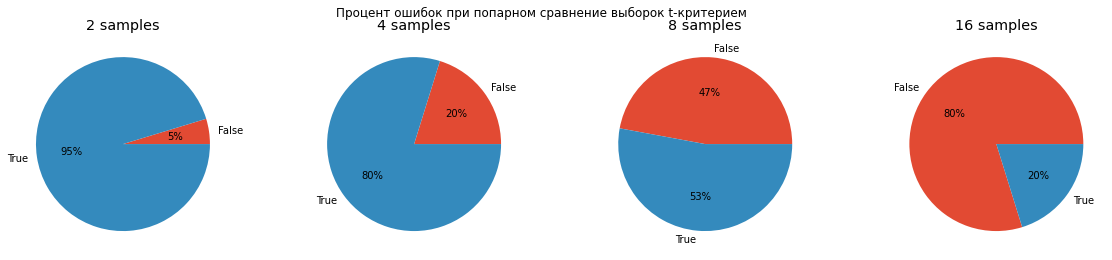

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
n_samples = [2, 4, 8, 16]
fig.suptitle('Процент ошибок при попарном сравнение выборок t-критерием')

for n, ax in zip(n_samples, axs):
    pair_t_test(1000, n, 30, ax)
    ax.set_title(f'{n} samples')
    

Как мы и ожидаем, степень ошибки равна **5%**, при сравнение **двух выборок** из одной ГС с помощью t-критерия с p-уровнем значимости **95%**. Если мы возмём **4** выборки, и сравним их попарно, то ошибка возрастёт в **4** раза до **20%**. При **8** выборок, наша ошибка возрасла почти в **9** раз до **46%**. **16** выборок дают увеличение ошибки до **80%** ( в 16 раз), что совершенно неприемлемо.

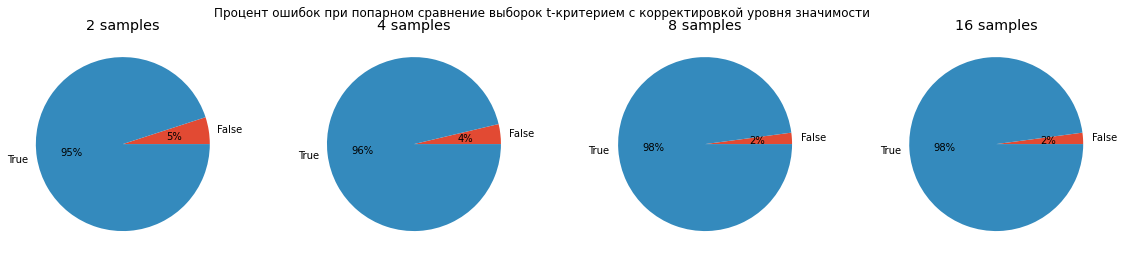

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
n_samples = [2, 4, 8, 16]
fig.suptitle('Процент ошибок при попарном сравнение выборок t-критерием с корректировкой уровня значимости')

for n, ax in zip(n_samples, axs):
    alpha = 0.05/((n*(n-1))/2) # делим на число сравнений = ((n*(n-1))/2) - поправка Бонферрони 
    pair_t_test(1000, n, 30, ax, alpha)
    ax.set_title(f'{n} samples')

Однако в данном случае эта будет арх-консервативная корректировавка, которая имеет меньше вероятность найти реальные значения. По сути мы **уменьшаем шанс получить ошибку I рода, но увеличиваем шанс на ошибку II рода**.


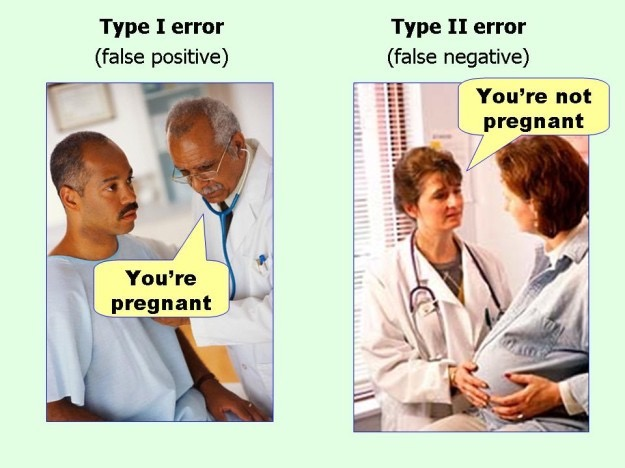

In [ ]:
Image('/content/АБ_тестирование/error_types.jpeg')


### Задача ( датасет 4 группы)
<div class="alert alert-info">
  
Проанализируйте синтетический датасет с данными. У вас есть наблюдения по 4 группам попытайтесь придумать кейс, когда вы анализируете некий признак в 4 группах. Что это за группы? Какие выводы можно сделать понаблюдав за тем как распределены данные и что показывают у нас тесты?    
</div>

In [ ]:
df =\
    pd.DataFrame([[25, 45, 30, 54],
                  [30, 55, 29, 60],
                  [28, 29, 33, 51],
                  [36, 56, 37, 62],
                  [29, 40, 27, 73]],
                 columns=['A', 'B', 'C', 'D'])
df

,A,B,C,D
0,25,45,30,54
1,30,55,29,60
2,28,29,33,51
3,36,56,37,62
4,29,40,27,73


In [ ]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.columns = ['index', 'treatments', 'value']

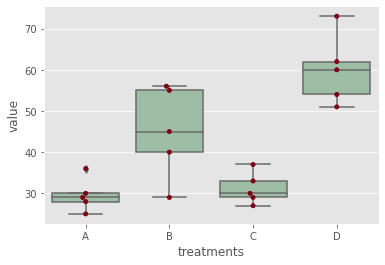

In [ ]:
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()

In [ ]:
fvalue, pvalue = st.f_oneway(df['A'], df['B'], df['C'], df['D'])

print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=17.493, p=0.000026
Отклоняем нулевую гипотезу, средние, вероятно, различаются


In [ ]:
groups = ['A','B','C','D']
names = [];
for k1 in range (len(groups)):
    for k2 in range(len(df['A'])):
        names.append(groups[k1])

In [ ]:
tukey = pairwise_tukeyhsd(endog=pd.concat([df['A'], df['B'],df['C'],df['D']]).values,
                          groups=names,
                          alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B     15.4 0.0251   1.6929 29.1071   True
     A      C      1.6    0.9 -12.1071 15.3071  False
     A      D     30.4  0.001  16.6929 44.1071   True
     B      C    -13.8 0.0482 -27.5071 -0.0929   True
     B      D     15.0 0.0296   1.2929 28.7071   True
     C      D     28.8  0.001  15.0929 42.5071   True
-----------------------------------------------------


Вывод: Гипотеза H0 о различии средних в выборках A и C отвергается. Данные можно объединить в 1 группу

### Задача - об измерении раковины мидии

<div class="alert alert-info">   
    
Есть некоторые данные об измерении раковины  у мидии Mytilus trossulus из пяти мест: 
Тилламук, Ньюпорт, Петербург, Аляска, Магадан и Твермин.
    
Осуществить дисперсионный анализ, визуализируйте данные. 
    
Если удастся визуально выделить данные в группы (например 2 города в одной, 3 в другой), сравнить выборки внутри полученных групп.   
</div>

In [ ]:
tillamook = [0.0571, 0.0813, 0.0831, 0.0976,
             0.0817, 0.0859, 0.0735, 0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835, 0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764, 0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]

In [ ]:
# Еще один способ преобразования списков в датафрейм через словарь - но тогда способ из предыдущей задачи не подойдет
data_dict=dict()
data_dict['tillamook']=tillamook
data_dict['newport']=newport
data_dict['petersburg']=petersburg
data_dict['magadan']=magadan
data_dict['tvarminne']=tvarminne
data = pd.DataFrame.from_dict(data_dict,orient='index').T

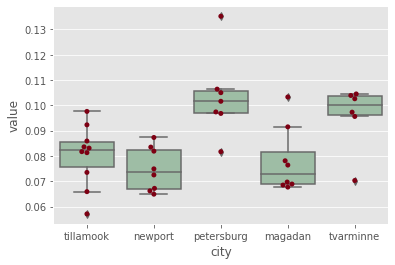

In [ ]:
# Визуализация
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'city', 'value']
df_melt = df_melt[df_melt['value'].notna()]
names = list(df_melt['city'])
ax = sns.boxplot(x='city', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="city", y="value", data=df_melt, color='#7d0013')
plt.show()

In [ ]:
# Дисперсионный анализ
fisher_test(data)

Нулевая гипотеза: tillamook=newport=petersburg=magadan=tvarminne
Альтернативная гипотеза: !(tillamook=newport=petersburg=magadan=tvarminne)
Результат:
отклоняем нулевую гипотезу
p_value = 0.0002812242314534544,  f-значение = 7.121019471642449


In [ ]:
tukey = pairwise_tukeyhsd(endog=pd.concat([data[data['tillamook'].notna()]['tillamook'], data[data['newport'].notna()]['newport'],data[data['petersburg'].notna()]['petersburg'],data[data['magadan'].notna()]['magadan'], data[data['tvarminne'].notna()]['tvarminne']]).values,
                          groups=names,
                          alpha=0.05)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
   magadan    newport  -0.0032    0.9 -0.0213  0.0149  False
   magadan petersburg   0.0254 0.0037  0.0067  0.0442   True
   magadan  tillamook   0.0022    0.9  -0.015  0.0194  False
   magadan  tvarminne   0.0177 0.0928 -0.0019  0.0373  False
   newport petersburg   0.0286  0.001  0.0099  0.0474   True
   newport  tillamook   0.0054 0.8898 -0.0118  0.0226  False
   newport  tvarminne   0.0209 0.0318  0.0013  0.0405   True
petersburg  tillamook  -0.0232 0.0057 -0.0411 -0.0054   True
petersburg  tvarminne  -0.0077 0.7791 -0.0279  0.0124  False
 tillamook  tvarminne   0.0155 0.1446 -0.0032  0.0342  False
------------------------------------------------------------


Как видно из боксплотов, во всех группах, кроме newport, есть выбросы.Это мешают аккуратно объединить города в общие группы. ЕСли их исключить, то кажется, что группы tillamook, newport и magadan имеют близкие средние значения ( группа 1), а также petersburg и twarminnie(группа 2)

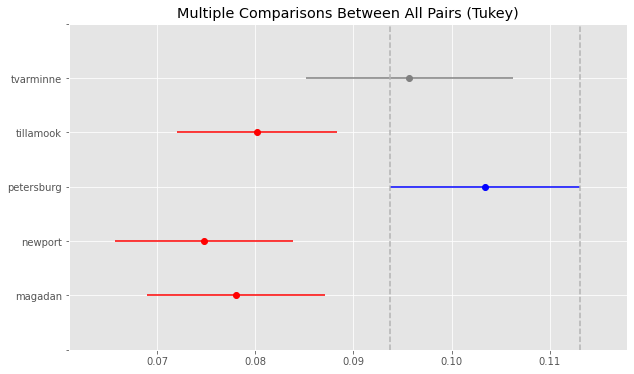

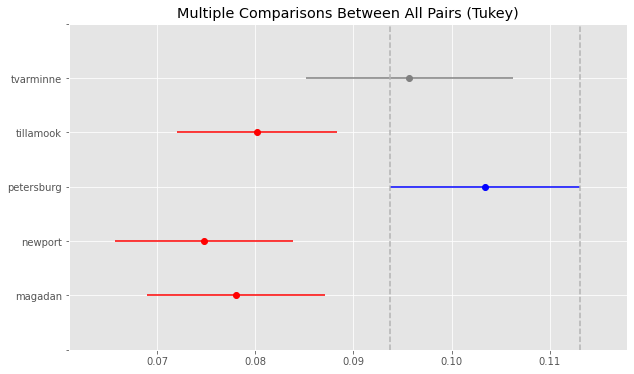

In [ ]:
tukey.plot_simultaneous(comparison_name="petersburg")

Вывод: в 1 группу можно объединить magadan, newport,tillamook  
во 2 группу - petersburg и tvarminne  

---



In [ ]:
df_melt.loc[(df_melt['city'].str.contains('magadan|newport|tillamook', case = False)), 'new_group'] = 'group_1'
df_melt.loc[(df_melt['city'].str.contains('petersburg|twarminnie', case = False)), 'new_group'] = 'group_2'


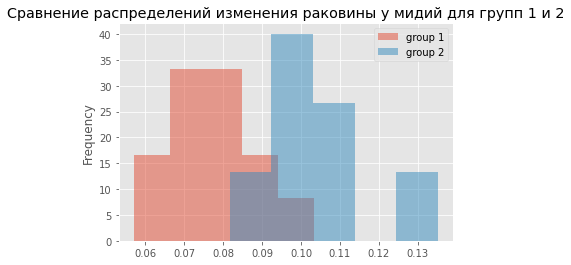

In [ ]:
# сравнить выборки внутри полученных групп.
group1 = list(df_melt[df_melt['new_group']=='group_1']['value'])
group2 = list(df_melt[df_melt['new_group']=='group_2']['value'])
df_melt[df_melt['new_group']=='group_1']['value'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=5,
                     density = True)

df_melt[df_melt['new_group']=='group_2']['value'].plot(kind='hist',  
                     alpha = 0.5,
                     bins=5,
                     density = True)

plt.legend(['group 1', 'group 2'],loc='upper right')
plt.title('Сравнение распределений изменения раковины у мидий для групп 1 и 2')
plt.show()


In [ ]:
fvalue, pvalue = st.f_oneway(df_melt[df_melt['new_group']=='group_1']['value'], df_melt[df_melt['new_group']=='group_2']['value'])

print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=23.875, p=0.000030
Отклоняем нулевую гипотезу, средние, вероятно, различаются


### Задачи с самостоятельным выбором теста

**Замечание: 1** Предполагается, что для решения заданий  № 1-3 будут использоваться разные тесты.

Если возникают сложности по ходу решения - пиште свой вопрос в общий чат в Slack. Там всегда подскажут) 




#### Задание 1.

Вам даны результаты проверки двух препаратов.
    
Требуется:
- Оценить, есть ли различие в эффекте у этих пациентов?
- Визуально подтвердить результат
    
`A` - результаты для группы людей получающих препарат А.

`B` - результаты для другой группы людей, получающих препарат B.    


In [ ]:
np.random.seed(11)
A = st.norm.rvs(scale=30, loc=11, size=100)
B = A + st.norm.rvs(scale=54, loc=11, size=100)

In [ ]:
# H0: Средние, вероятно, одинаковы,различий в эффекте от приема A и B нет
data = pd.DataFrame()
data['A'] = A.tolist()
data['B'] = B.tolist()

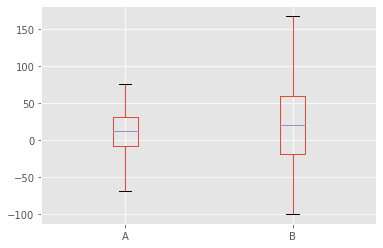

In [ ]:
data.boxplot() 
plt.show()
# визуально средние выглядят одинаковыми, 
# необходимо проверять с помощью тестов (необходимость проверки иллюстрирует следующая задача)

In [ ]:
# Проверяем, есть ли различие в дисперсиях в A и B 
#H0: дисперсии, вероятно, одинаковы
fisher_test(data)

Нулевая гипотеза: A=B
Альтернативная гипотеза: !(A=B)
Результат:
Не отклоняем нулевую гипотезу
p_value = 0.08451003973499746,  f-значение = 3.006064684269274


In [ ]:
stat, p = st.ttest_ind(A, B)
# stat, p = st.ttest_ind(A, B, equal_var = False)
print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые и различий в эффекте от препаратов A и B нет')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')


Статистика=-1.734, p=0.085
Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые и различий в эффекте от препаратов A и B нет


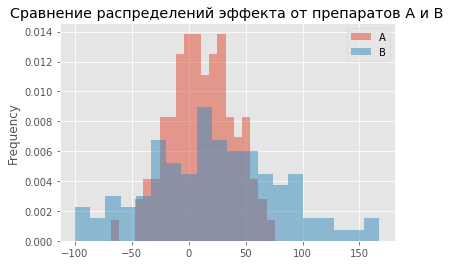

In [ ]:
data['A'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=20,
                     density = True)

data['B'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=20,
                     density = True)

plt.legend(loc='upper right')
plt.title('Сравнение распределений эффекта от препаратов A и B')
plt.show()

Пояснения: 
Т.к. мы изначально генерировали обе выборки как имеющие нормальное распределение, то к ним можно применить параметрический тест Стьюдента.

Наблюдения внутри каждой выборки независимы друг от друга (в условии указано "для другой группы людей").
Будем применять st.ttest_ind() 

Если дисперсии отличаются (можно проверить с помощью F-теста) то нужно использовать поправку Уэлча (Welch). В scipy это реализовано через параметр функции ttest_ind: equal_var = False. Но здесь не понадобилось, дисперсии одинаковы 


#### Задание № 2
Вам даны результаты проверки двух групп пациентов. 
    
Требуется: 
- Оценить, есть ли различие в эффекте у этих пациентов?
- Визуально подтвердить результат
    
`А` - группа людей без препарата.

`B` - та же группа людей, но получающая препарат

In [ ]:
np.random.seed(11)
A = st.norm.rvs(scale=30, loc=11, size=100)
B = A + st.norm.rvs(scale=54, loc=11, size=100)
# H0: средние значения A и B равны ( эффекта от приема препарата нет)
# Равенство дисперсий проверяли в предыдуще задаче, выборки те же
stat, p = st.ttest_rel(A, B)
# stat, p = st.ttest_rel(A, B, equal_var = False)  # 
print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые и различий в эффекте от приема препарата и плацебо нет')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются и эффект от приема препарата есть')

Статистика=-2.170, p=0.032
Отклоняем нулевую гипотезу, средние, вероятно, различаются и эффект от приема препарата есть


Пояснения: 
Т.к. мы изначально генерировали обе выборки как имеющие нормальное распределение, то к ним можно применить параметрический тест Стьюдента.

Наблюдения внутри каждой выборки связаны  друг с другом , тестирование "до" и "после" (в условии указано "та же группа людей").
Будем применять st.ttest_rel()

Если дисперсии отличаются (можно проверить с помощью F-теста) то нужно использовать поправку Уэлча (Welch). В scipy это реализовано через параметр функции ttest_rel: equal_var = False. Здесь не поадобилось (дисперсии одинаковы)
)

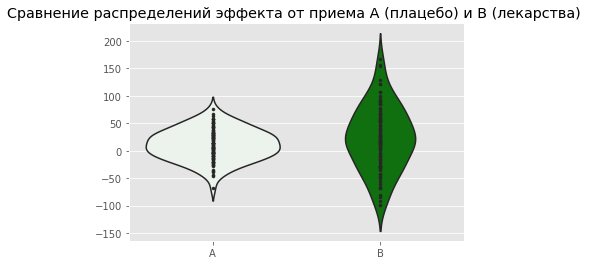

In [ ]:
data = pd.DataFrame()
data['A'] = A.tolist()
data['B'] = B.tolist()
sns.violinplot(data=data, palette="light:g", inner="points", orient="v")
plt.title('Сравнение распределений эффекта от приема A (плацебо) и B (лекарства) ')
plt.show()

#### Задание № 3
Допустим вы решили устроить дачный эксперимент. Берем и поливаем одни огурцы водой (water), другие огурцы водой с удобнением (nutri), третью группу огурцов будем поливать минералкой (mineral). 
    
 - Используя дисперсионный анализ, сделайте выводы о распредлениях результатов. Есть ли эффект от удобрения по сравнению с минералкой? 
 - Помимо результата статистического теста, продемонстрируйте отличия визуально с помощью `boxplot` или `hist`

In [ ]:
water = [1, 2, 3, 4, 2, 4, 2, 4, 5, 2, 3, 4, 2, 1, 3, 4, 3, 2, 5, 1]
nutri = [1, 2, 4, 6, 5, 6, 7, 5, 4, 5, 6, 7, 4, 3, 5, 5, 6, 5, 4, 3, 5]
mineral = [2, 1, 1, 3, 2, 4, 2, 4, 5, 4, 3, 2, 3, 2, 3, 1, 3, 4, 5, 1, 4]

In [ ]:
data_dict={'water' : water, 'nutri' : nutri,  'mineral' : mineral}
data=pd.DataFrame.from_dict(data_dict,orient='index').T
# В датафрейме появились значения nan из-за разницы в количестве элементов в списках. В дальнейшем nan отфильтровываются

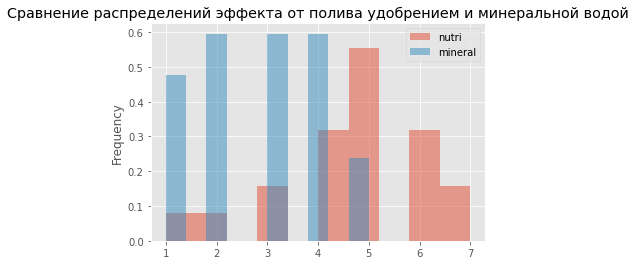

In [ ]:
# визуализация с помощтью гистограммы
# data['water'].plot(kind='hist', 
#                      alpha = 0.5,
#                      bins=10,
#                      density = True)


data['nutri'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=10,
                     density = True)
data['mineral'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=10,
                     density = True)
plt.legend(loc='upper right')
plt.title('Сравнение распределений эффекта от полива удобрением и минеральной водой')
plt.show()

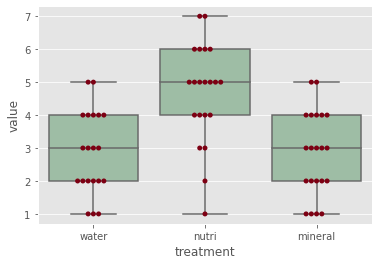

In [ ]:
# Визуализация посредством boxplot
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'treatment', 'value']
df_melt = df_melt[df_melt['value'].notna()]
names = list(df_melt['treatment'])
ax = sns.boxplot(x='treatment', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="treatment", y="value", data=df_melt, color='#7d0013')
plt.show()

На боксплоте кажется, что нет принципиальных различий между группами water и mineral. Но это нужно прооверять

Пояснения.
Т.к у нас >2 выборок, критерий Стьюдента использовать нежелательно. Будем применять однофакторный дисперсионный анализ

In [ ]:
# Н0: дисперсии равны
fisher_test(data)

Нулевая гипотеза: water=nutri=mineral
Альтернативная гипотеза: !(water=nutri=mineral)
Результат:
отклоняем нулевую гипотезу
p_value = 2.924004790632673e-05,  f-значение = 12.525963044834201


In [ ]:
tukey = pairwise_tukeyhsd(endog=df_melt['value'].to_numpy(),
                          groups=df_melt['treatment'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
mineral  nutri   1.8571 0.001   0.842  2.8723   True
mineral  water   0.0405   0.9 -0.9873  1.0683  False
  nutri  water  -1.8167 0.001 -2.8445 -0.7889   True
----------------------------------------------------


 pairwise_tukeyhsd выявил, что статистически достоверных  различий в эффекте от water и mineral нет ( нулевая гипотеза о равенстве средних была отвергнута), зато, вероятно, есть различия в эффекте от nutri и mineral

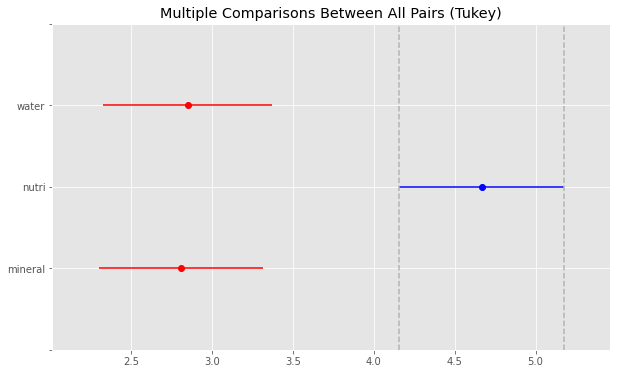

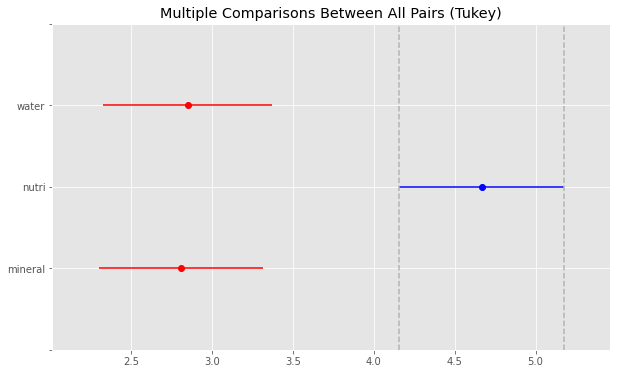

In [ ]:
# визуализация с помощью построения доверительных интервалов для средних
tukey.plot_simultaneous(comparison_name="nutri")

Вывод: Эффект от удобрения по сравнению с минеральной водой есть. Доверительные интервалы для mineral и nutri не пересекаются, а среднее значение и доверительный интервал  для nutri лежит  в области более высоких значений урожайности. Следует применять полив с удобрением

#### Задание 4
Проанализируем ещё один датасет. Здесь снова данные по урожайности в зависимости от типа используемого удобрения. 
    
Предлагаю самостоятельно исследовать данные и проверить гипотезы, используя тесты, изученные в течение курса
Допустим, вы должны помочь агроному выбрать тип удобрения. Какой вы посоветуете и почему? 



In [ ]:
data = pd.read_csv('/content/АБ_тестирование/PlantGrowth.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  30 non-null     int64  
 1   weight      30 non-null     float64
 2   group       30 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 848.0+ bytes


In [ ]:
data.group.value_counts()

ctrl    10
trt1    10
trt2    10
Name: group, dtype: int64

Выборка из 30 элементов. Пустые значения отсутствуют. 3 колонки - Unnamed(видимо,номер опыта), weight - урожайность, group - принадлежность к группе в зависимости от используемого удобрения. Выделено 3 группы - контрольная (ctrl), удобрение 1(trt1) и удобрение 2(trt2). В каждой группе - по 10 элементов.

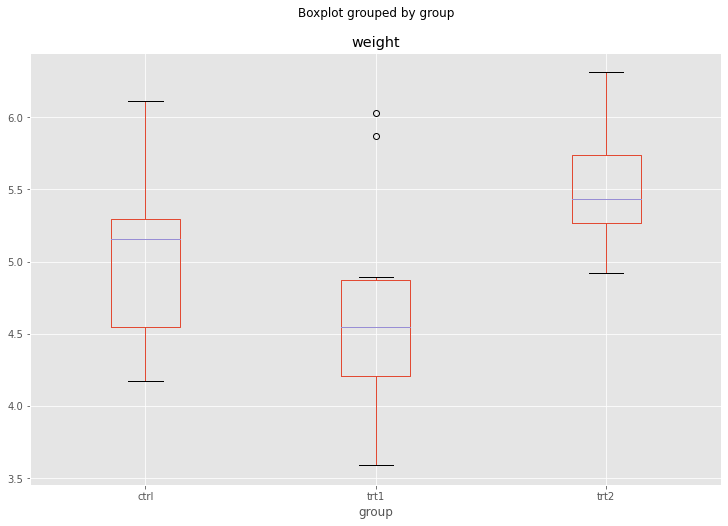

In [ ]:
data.boxplot('weight', by='group', figsize=(12, 8))
plt.show()

Из построенных боксплотов складывается впечатление, что все 3 выборки различны, средняя урожайность по trt1  ниже, чем в контрольной группе ( без удобрений), а средняя урожайность по trt2 выше, чем в контрольной группе. Но это предположение требует проверки. Выполним однофакторный дисперсионный анализ
H0: ctrl = trt1 = trt2

In [ ]:
fvalue, pvalue = st.f_oneway(data[data['group']=='ctrl']['weight'].to_numpy(), data[data['group']=='trt1']['weight'].to_numpy(), data[data['group'] =='trt2']['weight'].to_numpy())

print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=4.846, p=0.015910
Отклоняем нулевую гипотезу, средние, вероятно, различаются


Была отклонена H0 о равенстве ctrl=trt1=trt2. Теперь выясним, есть ли разница в выборках с применением удобрений (trt1 и trt2)

In [ ]:
trt1 = data[data['group']=='trt1']['weight']
trt2 = data[data['group']=='trt2']['weight']
ctrl = data[data['group']=='ctrl']['weight']
tukey = pairwise_tukeyhsd(endog=pd.concat([ctrl,trt1,trt2]),
                           groups=data['group'],
                           alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  ctrl   trt1   -0.371 0.3921 -1.0621 0.3201  False
  ctrl   trt2    0.494  0.198 -0.1971 1.1851  False
  trt1   trt2    0.865  0.012  0.1739 1.5561   True
---------------------------------------------------


При множественном сравнении средних не выявлено статистически достоверных различий в эффекте от использования trt1 и trt2 по сравнению с контрольной группой. Однако средние значения урожайности по группам trt1 и trt2 различны. Основная причина -  в том, что trt1, похоже, отрицательно сказывается на урожайности

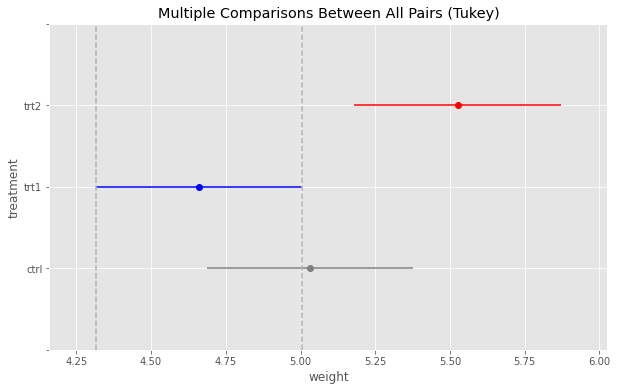

In [ ]:
tukey.plot_simultaneous(comparison_name='trt1',xlabel = 'weight', ylabel='treatment')
plt.show()

Если посмотреть на визуализацию с помощью доверительных интервалов, можно заметить, что в trt1 интервал смещается сторону меньших значений по сравнению с ctrl, а trt2 - в сорону больших. Но и trt1, и trt2 пересекаются с ctrl

In [ ]:
dd=pd.DataFrame()
dd['ctrl']=ctrl.tolist()
dd['trt1']=trt1.tolist()
dd['trt2']=trt2.tolist()

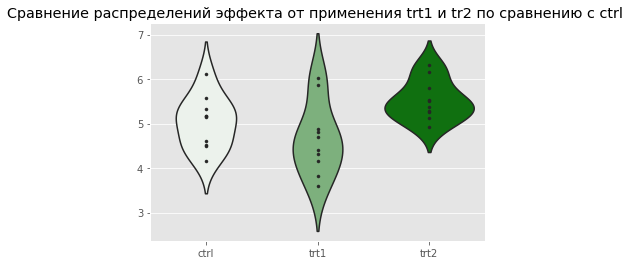

In [ ]:
sns.violinplot(data =dd, palette="light:g", inner="points", orient="v")

plt.title('Сравнение распределений эффекта от применения trt1 и tr2 по сравнению с ctrl ')
plt.show()

Вывод: Не рекомендуется использовать trt1. Продолжить исследования по использованию trt2 ( небольшой объем выборки). В настоящее время нет достаточных оснований для принятия однозначного решения об использовании trt2, разве что цена вопроса незначительна по сравнению с общим увеличением средней урожайности

## A/B - тесты

### Cookie Cats

<div class="alert alert-info">
Cookie Cats - чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая игра-головоломка в стиле «соедините три», в которой игрок должен соединять плитки одного цвета, чтобы очистить поле и выиграть уровень. Здесь также есть поющие кошки. 
</div>

<p style="align: center;"><img align=center src="https://i.ytimg.com/vi/iPxZIp0cbJE/maxresdefault.jpg"  width=500></p>
 
 
<p style="align: center;"><img align=center src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png"  width=500></p>


<div class="alert alert-info">
По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать нетривиальное количество времени или совершать покупки в приложении, чтобы продолжить. Помимо стимулирования покупок в приложении, эти ворота служат важной цели - дать игрокам вынужденный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия от игры.
</div>

<div class="alert alert-info">
<b>Но где ставить ворота? </b>
Первоначально первые ворота были размещены на уровне 30. В этом проекте вам предлагается проанализировать AB-тест, в котором создатели переместили первые ворота в Cookie Cats с 30 уровня на уровень 40. В частности, вам надо рассмотрим влияние A/B теста на удержание игроков.
</div>

### Данные A/B тестирования

**Данные получены от 90 189 игроков, которые установили игру во время проведения AB-теста. Переменные:**

* `userid` - уникальный номер, идентифицирующий каждого игрока.

* `version` - был ли игрок помещен в контрольную группу (gate_30 - ворота на уровне 30) или в тестовую группу (gate_40 - ворота на уровне 40).

* `sum_gamerounds` - количество игровых раундов, сыгранных игроком в течение первой недели после установки
* `retention_1` - игрок вернулся и поиграл через 1 день после установки?
* `retention_7` - игрок вернулся и играл через 7 дней после установки?
* `exit` - игрок загрузил игру, но не стал играть ни на следующий день, ни через неделю?
* `both` - игрок  вернулся и поиграл и через 1 день, и через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначали `gate_30` или `gate_40`.

<div class="alert alert-info">
<b>Задание: провести анализ данных и сделать выводы о лучшем месте для установки ворот. </b>
    
Замечание: приведенных вспомогательных фрагментов кода не хватает для ответа на вопрос. 
Делать выводы необходимо опираясь на статистические тесты, разобранные в лекции. Большим плюсом будет построение визуализиции для подтверждения ваших выводом. Рекомендую использовать `seaborn` c его `sns.boxplot`/`sns.carplot`, `sns.barplot`, но можно обойтись и обычным `matplotlib`
</div>

In [ ]:
data = pd.read_csv('/content/АБ_тестирование/cookie_cats.csv', error_bad_lines=False)  # Откроем датасет
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Подготовка данных

In [ ]:
# проверим, есть ли среди игроков те, кто не играл вообще в течение недели? - да, их 3994
# они ничего не знают о том, где установлены ворота, поэтому их и рассмотрения удаляем
data[data['sum_gamerounds']==0]

,userid,version,sum_gamerounds,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False
...,...,...,...,...,...
90067,9986185,gate_30,0,False,False
90093,9988600,gate_40,0,False,False
90116,9990773,gate_30,0,False,False
90147,9994604,gate_30,0,False,False


In [ ]:
exit = data[data['sum_gamerounds']==0]
data.drop(exit.index, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86195 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          86195 non-null  int64 
 1   version         86195 non-null  object
 2   sum_gamerounds  86195 non-null  int64 
 3   retention_1     86195 non-null  bool  
 4   retention_7     86195 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.8+ MB


In [ ]:
# Те из игроков, кто сыграл менее 30 раундов и играет в gate_30, также ничего не знает об установленных воротах, их рассмотрения удаляем
exit = data[(data['sum_gamerounds']<=29) & (data['version'] =='gate_30')]
data.drop(exit.index, inplace = True)
# Те из игроков, кто сыграл менее 40 раундов и играет в gate_40, также ничего не знает об установленных воротах, их рассмотрения удаляем
exit = data[(data['sum_gamerounds']<=39) & (data['version'] =='gate_40')]
data.drop(exit.index, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30483 entries, 1 to 90187
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          30483 non-null  int64 
 1   version         30483 non-null  object
 2   sum_gamerounds  30483 non-null  int64 
 3   retention_1     30483 non-null  bool  
 4   retention_7     30483 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 1012.1+ KB


Построим гистограмму распределения  sum_gameround для обеих групп. Т.к в выборке -очень большое кол-во элементов,поэтому введем ограничение sum_gameround < 200 ( игроков с суммой раундов >200 мало, уберем пока их из рассмотрения)

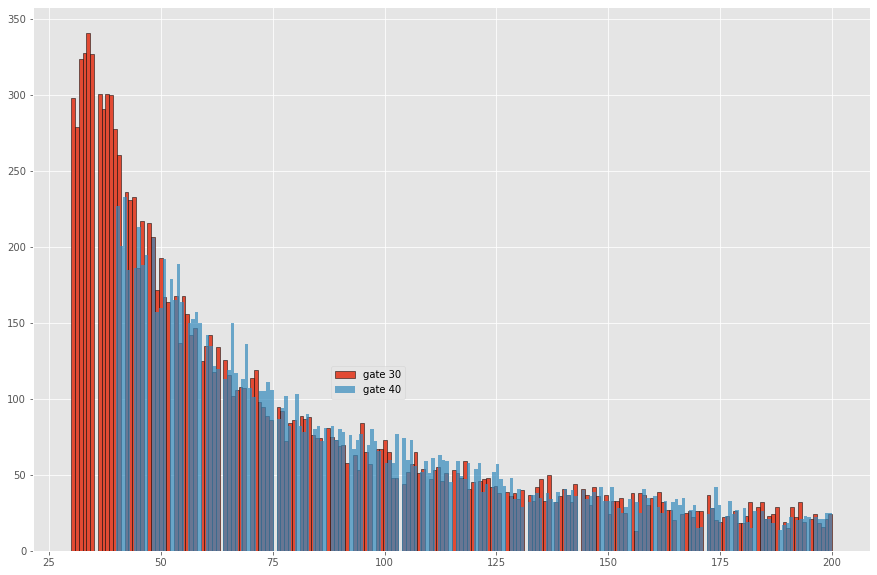

In [ ]:
v_30 = data.loc[data.version == 'gate_30']
v_40 = data.loc[data.version == 'gate_40']
v_30 = v_30.drop(v_30.loc[v_30.sum_gamerounds > 200].index)
v_40 = v_40.drop(v_40.loc[v_40.sum_gamerounds > 200].index)


bins = 200
plt.figure(figsize=(15, 10))
plt.hist(v_30['sum_gamerounds'], bins=bins, alpha=1,
         edgecolor='black', label='gate 30')
plt.hist(v_40['sum_gamerounds'], bins=bins, alpha=0.7, label='gate 40')
plt.legend(loc='upper right', bbox_to_anchor=(0.45, 0.35))
plt.show()

 Распределение количества раундов - не нормальное, напоминает распределение Фишера. похожий характер для обеих версий. 

Проверим, остались ли в датасете записи об игроках, которые не играли ни в 1, ни в 7 день, но определенно играли между 1 и 7 днями?

In [ ]:
data[(data['retention_1']==False) & (data['retention_7']==False) ]

,userid,version,sum_gamerounds,retention_1,retention_7
33,3696,gate_30,50,False,False
38,4283,gate_30,103,False,False
56,5943,gate_40,76,False,False
57,6099,gate_40,138,False,False
72,7527,gate_30,80,False,False
...,...,...,...,...,...
90135,9991965,gate_30,71,False,False
90160,9996269,gate_30,143,False,False
90167,9997037,gate_40,44,False,False
90175,9998125,gate_30,30,False,False


Таких - более половины всей выборки

Проверим, есть ли игроки, которые играли и в 1 , и в 7 дни?

In [ ]:
data[(data['retention_1']==True) & (data['retention_7']==True) ]

,userid,version,sum_gamerounds,retention_1,retention_7
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
8,1574,gate_40,108,True,True
14,2218,gate_30,305,True,True
17,2451,gate_30,204,True,True
...,...,...,...,...,...
90125,9991408,gate_40,186,True,True
90127,9991540,gate_30,117,True,True
90134,9991949,gate_30,191,True,True
90150,9995412,gate_40,253,True,True


Да, таких также значительное количество

Изменим структуру датасета, добавив дополнительные столбцы 'other' и 'both' и пересчитаем значения в столбцах 'retention_7' и 'retention_1

In [ ]:
def both(row):
  """
  Вспомогательная функция для выявления игроков, которые играли в 1 и в 7 дни
  """
  if row.retention_1 == True and row.retention_7 == True:
    return True
  else:
    return False

In [ ]:
def other(row):
  """
  Вспомогательная функция для выявления игроков, которые играли в другие дни
  """
  if row.retention_1 == False and row.retention_7 == False:
    return True
  else:
    return False

In [ ]:
def ret7(row):
  """
  Вспомогательная функция для выявлeния игроков, которые вернулись к игре через 1 дней, но не через 7 день
  """
  if row.retention_1 == True and row.retention_7 == True and row.both ==True:
    return False
  else:
    return row.retention_7

In [ ]:
def ret1(row):
  """
  Вспомогательная функция для выявлeния игроков, которые вернулись к игре не через 1 день, а через 7 дней
  """
  if row.retention_1 == True and row.both ==True:
    return False
  else:
    return row.retention_1

In [ ]:
data['other'] = data.apply(other, axis = 1)
data['both']= data.apply(both, axis = 1)


In [ ]:
data['retention_7']=data.apply(ret7, axis=1)

In [ ]:
data['retention_1']=data.apply(ret1, axis=1)

In [ ]:
data[data['version']=='gate_30'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


user_count        4.981332e+06
sum_gamerounds    1.250785e+02
retention_1       4.320365e-01
retention_7       6.982469e-02
other             1.292027e-01
both              3.689361e-01
dtype: float64

In [ ]:
data[data['version']=='gate_30'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


user_count        2.872221e+06
sum_gamerounds    4.103144e+02
retention_1       4.953743e-01
retention_7       2.548590e-01
other             3.354342e-01
both              4.825311e-01
dtype: float64

In [ ]:
data[data['version']=='gate_40'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


user_count        5.028033e+06
sum_gamerounds    1.426678e+02
retention_1       4.149129e-01
retention_7       6.979099e-02
other             1.000217e-01
both              4.152745e-01
dtype: float64

In [ ]:
data[data['version']=='gate_40'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


user_count        2.878797e+06
sum_gamerounds    1.511984e+02
retention_1       4.927248e-01
retention_7       2.548037e-01
other             3.000398e-01
both              4.927871e-01
dtype: float64

In [ ]:
data.rename(columns ={'userid': 'user_count'}, inplace = True)
df=data.loc[:,['version','user_count','sum_gamerounds','retention_1', 'retention_7', 'other', 'both']].groupby('version')
df_sum=df.sum() # сколько всего раундов сыграно в версии gate_30 и gate_40 в течение недели, сколько всего возратов к игре через день после установки и сколько - через неделю
df_sum['user_count']=df['user_count'].count()


In [ ]:
df_sum # здесь разбиение по числу участников

,user_count,sum_gamerounds,retention_1,retention_7,other,both
version,,,,,,
gate_30,16656,2083307,7196,1163,2152,6145
gate_40,13827,1972668,5737,965,1383,5742


Таким образом, выделились следующие характеристики в каждой из групп: те, кто вернулся к игре на следующий день, те, кто вернулся через 7 дней, те, кто играли и через 1, и через 7 дней, и те, кто играли в другие дни( но не в 1 или 7).
Как можно заметить, число игроков в каждой из групп - различно.

In [ ]:
# разобъем sum_gamerounds по подгруппам
other = data.loc[(data['other']==True),['version','sum_gamerounds']]
both = data.loc[(data['both']==True),['version','sum_gamerounds']]
retention_1 = data.loc[(data['retention_1']==True),['version','sum_gamerounds']]
retention_7 = data.loc[(data['retention_7']==True),['version','sum_gamerounds']]

In [ ]:
# и по группам внутри подгрупп
other_30 = other[(other['version']== 'gate_30') & (other['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
other_40 = other[(other['version']== 'gate_40') & (other['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
both_30 = both[(both['version']== 'gate_30') & (both['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
both_40 = both[(both['version']== 'gate_40')& (both['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
retention_1_30 = retention_1[(retention_1['version']== 'gate_30') & (retention_1['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
retention_1_40 = retention_1[(retention_1['version']== 'gate_40') & (retention_1['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
retention_7_30 = retention_7[(retention_7['version']== 'gate_30') & (retention_7['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()
retention_7_40 = retention_7[(retention_7['version']== 'gate_40') & (retention_7['sum_gamerounds']<=200)]['sum_gamerounds'].to_numpy()

In [ ]:
data_dict = {'other_30' : other_30, 'other_40' : other_40, 'both_30': both_30, 'both_40' : both_40, 'retention_1_30' : retention_1_30, 'retention_1_40': retention_1_40, 'retention_7_30': retention_7_30, 'retention_7_40': retention_7_40}
ddd = pd.DataFrame.from_dict(data_dict,orient='index').T


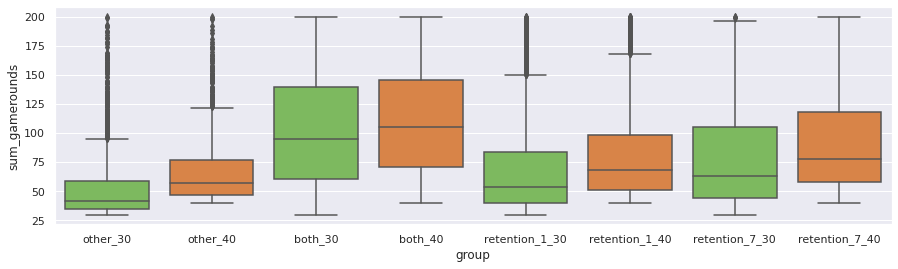

In [ ]:
# Визуализация
df_melt = pd.melt(ddd.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'group', 'sum_gamerounds']
df_melt = df_melt[df_melt['sum_gamerounds'].notna()]
names = list(df_melt['group'])
sns.set (rc={"figure.figsize":( 15 , 4 )}) 
#colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8','#99c2a2']
colors = ['#78C850', '#F08030']
ax = sns.boxplot(x='group', y='sum_gamerounds', data=df_melt, palette = colors)
#ax = sns.swarmplot(x="group", y="sum_gamerounds", data=df_melt, color='#7d0013')
plt.show()


В визуализации боксплотами складывается впечатление, чте средние значения всех 4 подгрупп при установке ворот на 40 уровень больше, чем при установке на 30 уровень. Но это нужно проверять

### Выборка

Определим необходимый размер выборки n

In [ ]:
ddd.sum()

other_30          111930.0
other_40           90215.0
both_30           413269.0
both_40           400364.0
retention_1_30    463492.0
retention_1_40    429375.0
retention_7_30     80615.0
retention_7_40     75320.0
dtype: float64

In [ ]:
n30 = len(other_30)+ len(both_30)+len(retention_1_30)+len(retention_7_30)
n40 = len(other_40)+ len(both_40)+len(retention_1_40)+len(retention_7_40)

In [ ]:
sigma_30 = 0.4954
sigma_40 = 0.4927
p_30 = ddd.retention_1_30.sum()/(ddd.retention_1_30.sum()+ddd.retention_1_40.sum()+ddd.retention_7_30.sum()+ddd.retention_7_40.sum()+ddd.other_30.sum()+ddd.other_40.sum())
p_40 = ddd.retention_1_40.sum()/(ddd.retention_1_30.sum()+ddd.retention_1_40.sum()+ddd.retention_7_30.sum()+ddd.retention_7_40.sum()+ddd.other_30.sum()+ddd.other_40.sum())
za = 1.96
zb = 0.84
Delta = 5
Ddec = Delta/100.

n1_30=int(np.ceil((za**2*p_30*(1-p_30)/Ddec**2)/(1+(za**2*p_30*(1-p_30)/(n30*Ddec**2)))))
n1_40=int(np.ceil((za**2*p_40*(1-p_40)/Ddec**2)/(1+(za**2*p_40*(1-p_40)/(n40*Ddec**2)))))

Принимаем за необходимый размер выборки 1000

In [ ]:
required_n = 1000
sample_30 = data[data['version'] == 'gate_30'].sample(n=required_n, random_state=22)
sample_40 = data[data['version'] == 'gate_40'].sample(n=required_n, random_state=22)

ab_test = pd.concat([sample_30, sample_40], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [ ]:
ab_test

,user_count,version,sum_gamerounds,retention_1,retention_7,other,both
0,4426887,gate_30,96,True,False,False,False
1,520692,gate_30,48,True,False,False,False
2,9759863,gate_30,34,False,False,True,False
3,1599264,gate_30,48,True,False,False,False
4,3017448,gate_30,86,True,False,False,False
...,...,...,...,...,...,...,...
1995,9016906,gate_40,63,False,False,False,True
1996,9763702,gate_40,50,True,False,False,False
1997,7105332,gate_40,76,True,False,False,False
1998,1638049,gate_40,127,True,False,False,False


### Визуализация

####sum_gamerounds

In [ ]:
sum_gamerounds_rates = ab_test.groupby('version')['sum_gamerounds']

std_p = lambda x: np.std(x, ddof=0)              
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

sum_gamerounds_rates = sum_gamerounds_rates.agg([np.mean, std_p, se_p])
sum_gamerounds_rates.columns = ['sum_gamerounds', 'сред. кв. отклонение', 'ошибка среднего']


sum_gamerounds_rates.style.format('{:.3f}')

,sum_gamerounds,сред. кв. отклонение,ошибка среднего
version,,,
gate_30,121.181,130.915,4.140
gate_40,137.955,138.377,4.376


Cреднее количество раундов на 1 игрока в gate_40 > чем в gate_30

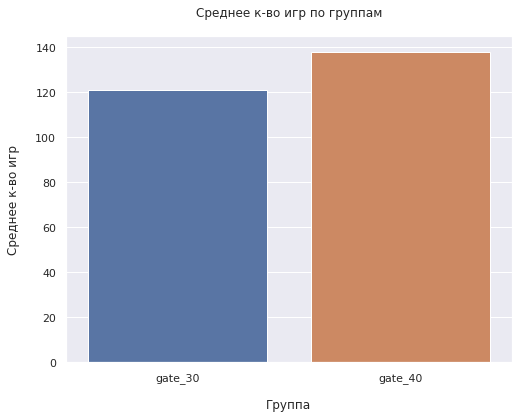

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], y=ab_test['sum_gamerounds'], ci=False)

plt.ylim(0, 145)
plt.title('Среднее к-во игр по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Среднее к-во игр', labelpad=15);

#### retention_1

In [ ]:
retention_1_rates = ab_test.groupby('version')['retention_1']

std_p = lambda x: np.std(x, ddof=0)              
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

retention_1_rates = retention_1_rates.agg([np.mean, std_p, se_p])
retention_1_rates.columns = ['retention_1', 'сред. кв. отклонение', 'ошибка среднего']


retention_1_rates.style.format('{:.3f}')

,retention_1,сред. кв. отклонение,ошибка среднего
version,,,
gate_30,0.398,0.489,0.015
gate_40,0.407,0.491,0.016


Судя по приведенной выше статистике, похоже, что Схема gate_40  cработала немного лучше - retention_1

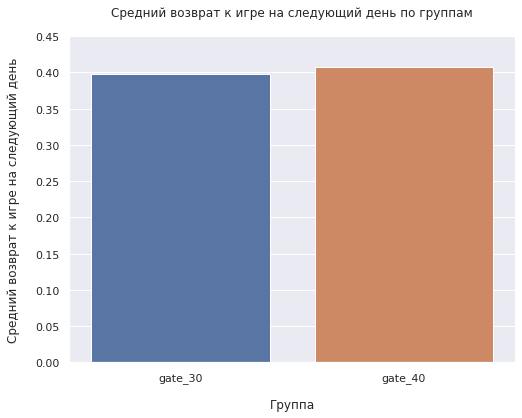

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], y=ab_test['retention_1'], ci=False)

plt.ylim(0, 0.45)
plt.title('Средний возврат к игре на следующий день по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Средний возврат к игре на следующий день', labelpad=15);

#### retention_7

In [ ]:
retention_7_rates = ab_test.groupby('version')['retention_7']

std_p = lambda x: np.std(x, ddof=0)              
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

retention_7_rates = retention_7_rates.agg([np.mean, std_p, se_p])
retention_7_rates.columns = ['retention_7', 'сред. кв. отклонение', 'ошибка среднего']


retention_7_rates.style.format('{:.3f}')

,retention_7,сред. кв. отклонение,ошибка среднего
version,,,
gate_30,0.071,0.257,0.008
gate_40,0.061,0.239,0.008


Судя по приведенной выше статистике, похоже, что Схема gate_30 cработала значительно лучше 



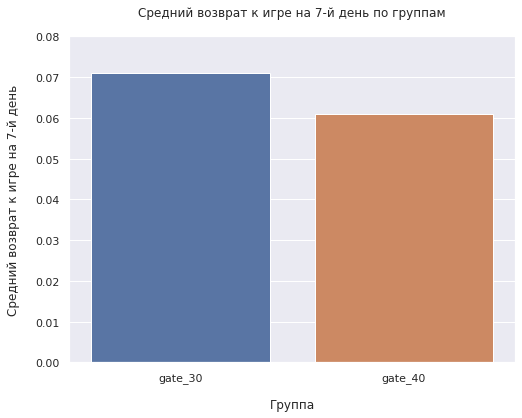

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], y=ab_test['retention_7'], ci=False)

plt.ylim(0, 0.08)
plt.title('Средний возврат к игре на 7-й день по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Средний возврат к игре на 7-й день', labelpad=15);

#### other

In [ ]:
other_rates = ab_test.groupby('version')['other']

std_p = lambda x: np.std(x, ddof=0)              
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

other_rates = other_rates.agg([np.mean, std_p, se_p])
other_rates.columns = ['other', 'сред. кв. отклонение', 'ошибка среднего']


other_rates.style.format('{:.3f}')

,other,сред. кв. отклонение,ошибка среднего
version,,,
gate_30,0.122,0.327,0.010
gate_40,0.102,0.303,0.010


Судя по приведенной выше статистике, похоже, что Схема gate_30 cработала немного лучше, чем gate_40

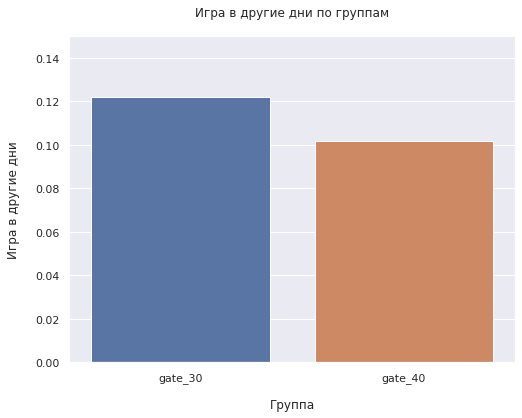

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], y=ab_test['other'], ci=False)

plt.ylim(0, 0.15)
plt.title('Игра в другие дни по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Игра в другие дни', labelpad=15);

#### both

In [ ]:
both_rates = ab_test.groupby('version')['both']

std_p = lambda x: np.std(x, ddof=0)              
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

both_rates = both_rates.agg([np.mean, std_p, se_p])
both_rates.columns = ['both', 'сред. кв. отклонение', 'ошибка среднего']


both_rates.style.format('{:.3f}')

,both,сред. кв. отклонение,ошибка среднего
version,,,
gate_30,0.409,0.492,0.016
gate_40,0.430,0.495,0.016


Судя по статистике, число играющих и на следующий день, и через 7 дней также больше для группы gate_30 -  0.152 против 0.143

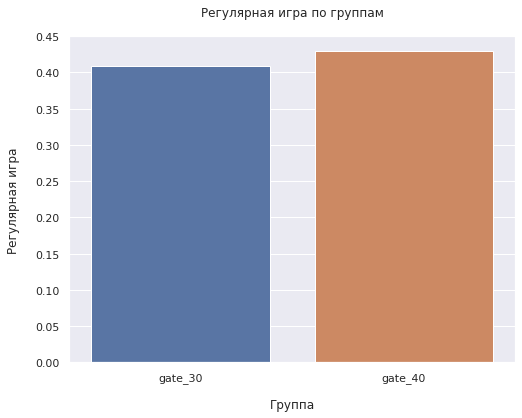

In [ ]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], y=ab_test['both'], ci=False)

plt.ylim(0, 0.45)
plt.title('Регулярная игра по группам', pad=20)
plt.xlabel('Группа', labelpad=15)
plt.ylabel('Регулярная игра', labelpad=15);

### Проверка гипотез

Здесь групп для сравнения всего 2 - gate_30 и gate_40, и распределение не нормально. Будем сравнивать, используя непараметрический тест Манна-Уитни

#### Среднее количество раундов игр на 1 участника  для gate_30  и gate_40 в интервале от 30 до 40 игр ( т.е именно тот участок, где игроки встречаются с воротами

In [ ]:
v_30_ = data.loc[(data.version == 'gate_30') & (data.sum_gamerounds>=30) & (data.sum_gamerounds<=40)]
v_40_ = data.loc[(data.version == 'gate_40') & (data.sum_gamerounds>=30) & (data.sum_gamerounds<=40)]

##### по Манну-Уитни

In [ ]:
#stat, p = mannwhitneyu(data[data['version'] == 'gate_30']['sum_gamerounds'], data[data['version'] == 'gate_40']['sum_gamerounds'])

stat, p = mannwhitneyu(ab_test[ab_test['version'] == 'gate_30']['sum_gamerounds'], ab_test[ab_test['version'] == 'gate_40']['sum_gamerounds'])

print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=412188.000, p=0.000
Отклоняем нулевую гипотезу, распределения, вероятно, различаются


#### Среднее число игравших в 1 день и не игравших на 7 день посе загрузки

##### по Манну-Уитни

In [ ]:
#stat, p = st.mannwhitneyu(v_30['retention_1'], v_40['retention_1'])
stat, p = mannwhitneyu(ab_test[ab_test['version'] == 'gate_30']['retention_1'], ab_test[ab_test['version'] == 'gate_40']['retention_1'])

print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=495500.000, p=0.682
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


#### Среднее число не игравших в 1 день и игравших на 7 день посе загрузки

##### по Манну - Уитни

In [ ]:
#stat, p = st.mannwhitneyu(v_30['retention_7'], v_40['retention_7'])
stat, p = mannwhitneyu(ab_test[ab_test['version'] == 'gate_30']['retention_7'], ab_test[ab_test['version'] == 'gate_40']['retention_7'])
print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=505000.000, p=0.368
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


#### Среднее число установивших игру, но не игравших ни в 1, ни в 7 день

##### по Манну-Уитни

In [ ]:
#stat, p = st.mannwhitneyu(v_30['other'], v_40['other'])
stat, p = mannwhitneyu(ab_test[ab_test['version'] == 'gate_30']['other'], ab_test[ab_test['version'] == 'gate_40']['other'])
print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=510000.000, p=0.156
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


#### Среднее число игравших и в 1, и на 7 день

#####по Манну-Уитни

In [ ]:
#stat, p = st.mannwhitneyu(v_30['both'], v_40['both'])
stat, p = mannwhitneyu(ab_test[ab_test['version'] == 'gate_30']['both'], ab_test[ab_test['version'] == 'gate_40']['both'])
print('Статистика=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика=489500.000, p=0.341
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


**Ваши выводы?** 

Таким образом, если применять непараметрический критерий Манн-Уитни ,  выявляются статистические различия в версиях gate_30 и gate_40 по количеству раундов среди игроков, сыгравших от 30 до 40 раундов (т.е как раз тех, кто столкнулся с воротами на 30 и 40 уровнях.
Кроме того, выявлены статистические различия по количеству раундов среди тех, кто играл не в 1 и не в 7 дни,  и среди игравших оба дня(1 и 7). 
Различий между игравшими в 1 и в 7 день для обоих версий не выявлено ни в одном из тестов. Видимо, причина в том, что в выборке много одинаковых значений и выбросов, и тест Манна-Уитни срабатывает некорректно

Применим Bootstrap для того, чтобы более наглядно убедиться в наличии или отсутствии различий

#### retention_1

In [ ]:
plt.figure(figsize=(15, 10))
# boot_1d - собираем статистику по средним, для неё можно применить t-тест
boot_1d = []
diff_1d = []
for i in range(required_n):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()  # retention_1
    boot_1d.append(boot_mean)
    boot_1d_30 = data.query('version=="gate_30"').sample(frac=1, replace = True).retention_1.mean()
    boot_1d_40 = data.query('version=="gate_40"').sample(frac=1, replace = True).retention_1.mean()
    diff_1d.append(boot_1d_30 - boot_1d_40)
# Преобразование списка в DataFrame
boot_1d = pd.DataFrame(boot_1d)
diff_1d = pd.DataFrame(diff_1d)

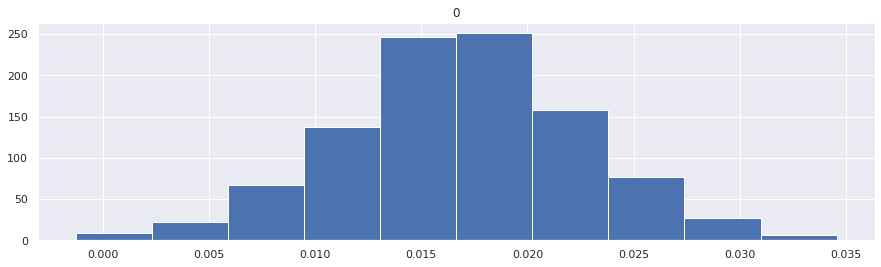

In [ ]:
diff_1d.hist()
plt.show()

In [ ]:
confidence_interval = diff_1d.quantile([0.025,0.975])
confidence_interval

,0
0.025,0.005478
0.975,0.027962


C вероятностью 95 % среднее число раундов на 1 игрока в группе игравших на следующий день после загрузки при перемещении ворот на 40 уровень уменьшилось на 0,5 - 2,8 %

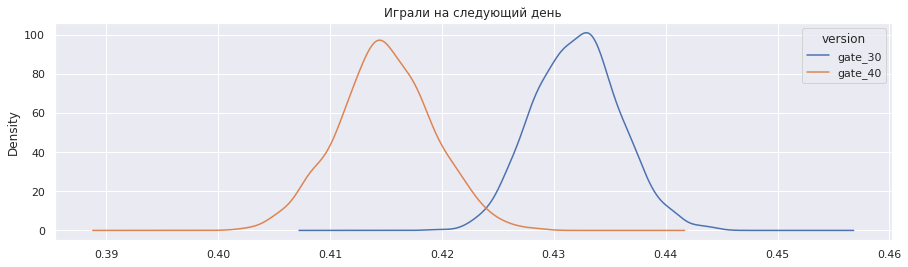

In [ ]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')
plt.title('Играли на следующий день')
plt.show()

In [ ]:
stat, p = st.ttest_ind(boot_1d['gate_30'], boot_1d['gate_40'])
print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=57.108, p=0.00000
Отклоняем нулевую гипотезу, средние, вероятно, различаются


#### retention_7

In [ ]:
plt.figure(figsize=(15, 10))
boot_7d = []
diff_7d = []
for i in range(required_n):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()  # retention_7
    boot_7d.append(boot_mean)
    boot_7d_30 = data.query('version=="gate_30"').sample(frac=1, replace = True).retention_7.mean()
    boot_7d_40 = data.query('version=="gate_40"').sample(frac=1, replace = True).retention_7.mean()
    diff_7d.append(boot_7d_30 - boot_7d_40)
# Преобразование списка в DataFrame
boot_7d = pd.DataFrame(boot_7d)
diff_7d = pd.DataFrame(diff_7d)

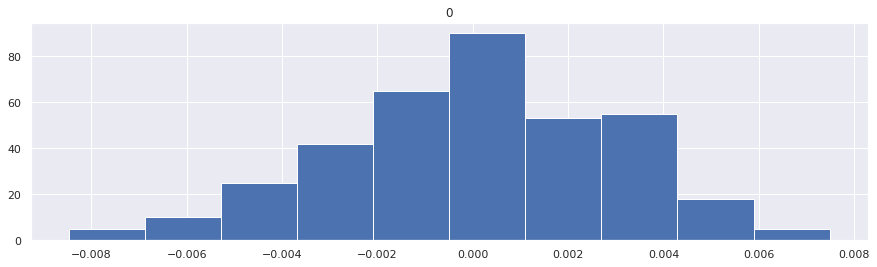

In [ ]:
diff_7d.hist()
plt.show()

In [ ]:
confidence_interval = diff_7d.quantile([0.025,0.975])
confidence_interval

,0
0.025,-0.005990
0.975,0.005559


C вероятностью 95 % среднее число раундов на 1 игрока в группе игравших на следующий день после загрузки при перемещении ворот на 40 уровень  изменилось на -0,5 - 0,5 % ( тоо есть не изменилось)

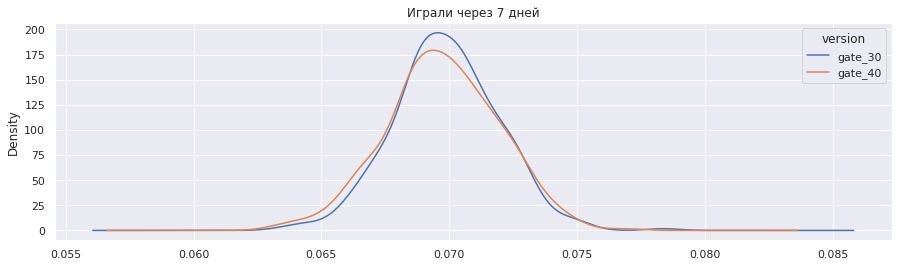

In [ ]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_7d.plot(kind='density')
plt.title('Играли через 7 дней')
plt.show()

In [ ]:
stat, p = st.ttest_ind(boot_7d['gate_30'], boot_7d['gate_40'])
print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=-1.945, p=0.05210
Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые


#### other

In [ ]:
plt.figure(figsize=(15, 10))
boot_other = []
diff_other = []
for i in range(required_n):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['other'].mean()  # other
    boot_other.append(boot_mean)
    boot_other_30 = data.query('version=="gate_30"').sample(frac=1, replace = True).other.mean()
    boot_other_40 = data.query('version=="gate_40"').sample(frac=1, replace = True).other.mean()
    diff_other.append(boot_other_30 - boot_other_40)
# Преобразование списка в DataFrame
boot_other = pd.DataFrame(boot_other)
diff_other = pd.DataFrame(diff_other)

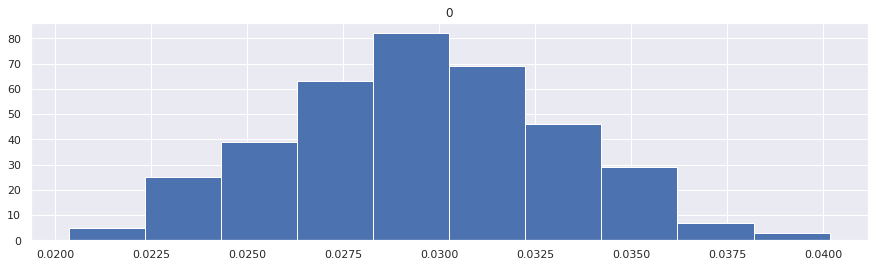

In [ ]:
diff_other.hist()
plt.show()

In [ ]:
confidence_interval = diff_other.quantile([0.025,0.975])
confidence_interval

,0
0.025,0.022757
0.975,0.036235


C вероятностью 95 % среднее число раундов на 1 игрока в группе игравших в другие дни после загрузки при перемещении ворот на 40 уровень уменьшилось на 2,3 - 3,6 %

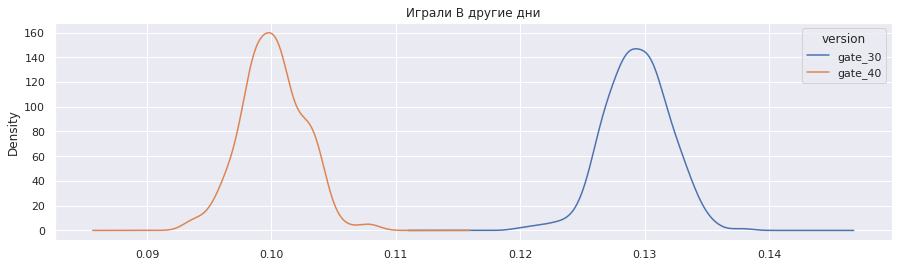

In [ ]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_other.plot(kind='density')
plt.title('Играли В другие дни')
plt.show()

In [ ]:
stat, p = st.ttest_ind(boot_other['gate_30'], boot_other['gate_40'])
print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=152.929, p=0.00000
Отклоняем нулевую гипотезу, средние, вероятно, различаются


#### both

In [ ]:
plt.figure(figsize=(15, 10))
boot_both  = []
diff_both = []
for i in range(required_n):
    boot_mean = data.sample(frac=1, replace=True).groupby(
        'version')['both'].mean()  # other
    boot_both.append(boot_mean)
    boot_both_30 = data.query('version=="gate_30"').sample(frac=1, replace = True).both.mean()
    boot_both_40 = data.query('version=="gate_40"').sample(frac=1, replace = True).both.mean()
    diff_both.append(boot_both_30 - boot_both_40)
# Преобразование списка в DataFrame
boot_both = pd.DataFrame(boot_both)
diff_both = pd.DataFrame(diff_both)

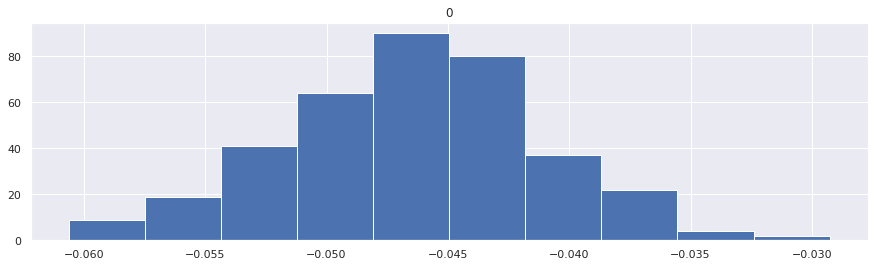

In [ ]:
diff_both.hist()
plt.show()

In [ ]:
confidence_interval = diff_both.quantile([0.025,0.975])
confidence_interval

,0
0.025,-0.057132
0.975,-0.036417


C вероятностью 95 % среднее число раундов на 1 игрока в группе игравших в другие дни после загрузки при перемещении ворот на 40 уровень увеличилось на 3,7 - 5,7 %

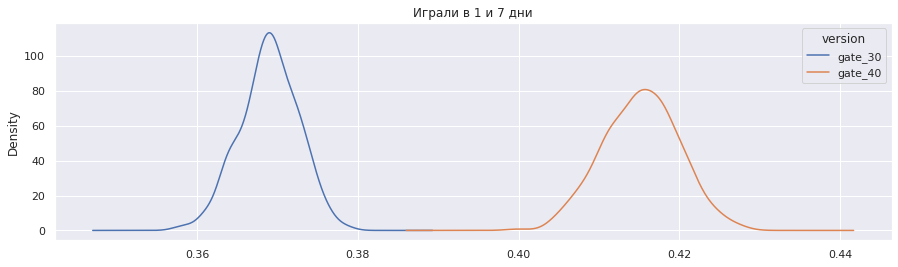

In [ ]:
# A Kernel Density Estimate plot of the bootstrap distributions
boot_both.plot(kind='density')
plt.title('Играли в 1 и 7 дни')
plt.show()

In [ ]:
stat, p = st.ttest_ind(boot_both['gate_30'], boot_both['gate_40'])
print('Статистика=%.3f, p=%.5f' % (stat, p))

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=-161.388, p=0.00000
Отклоняем нулевую гипотезу, средние, вероятно, различаются


**Выводы:**

Тестирование бутстрапа с применением тестов Стьюдента, напротив, дало другой результат - gate_30 и gate_40 различны. ПОчему так происходит и какому тестированию доверять?
https://koch-kir.medium.com/%D0%B8%D1%81%D1%82%D0%BE%D1%80%D0%B8%D1%8F-%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BE%D0%B1%D0%BC%D0%B0%D0%BD%D0%B0-%D0%B8%D0%BB%D0%B8-%D1%82%D1%80%D0%B5%D0%B1%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F-%D0%BA-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8E-%D0%B2-%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%85-55139a5558d

Если согласиться с выводами статьи, то бутстрап должен давать более близкие к реальному положению дел результаты. Основной вывод - gate_30 и gate_40 различны. Однако все изменения по среднему количеству раундов игры на игрока происходят в группах, которые играют в другие дни (не в 1 и 7) или играют в оба этих дня. Для игроков  из групп играющих в 1 или 7 день после загрузки статистически значимых изменений среднего количества раундов при смене ворот не происходит. Так что есть смысл более подробно изучить именно группы other и both, понять, какую долю от общего количества сыгранных игр дают эти группы, и вклад какой из них более существенен И уж тогда принимать решение о переносе или не переносе ворот

## Покемоны и AB-тестирование 
(реальный кейс собеседования на позицию Аналитика).

### Описание задачи

![banner](https://storage.googleapis.com/kaggle-datasets-images/635/1204/126be74882028aac7241553cef0e27a7/dataset-original.jpg)

Покемоны - это маленькие существа, которые сражаются друг с другом на соревнованиях. Все покемоны имеют разные характеристики (сила атаки, защиты и т. д.) И относятся к одному или двум так называемым классам (вода, огонь и т. д.).
Профессор Оук является изобретателем Pokedex, портативного устройства, которое хранит информацию обо всех существующих покемонах. Как его ведущий специалист по данным, Вы только что получили от него запрос с просьбой осуществить аналитику данных на всех устройствах Pokedex. 

### Описание набора данных

Профессор Оук скопировал все содержимое память одного устройства Pokedex, в результате чего получился набор данных, с которым Вы будете работать в этой задаче. В этом файле каждая строка представляет характеристики одного покемона:

* `pid`: Numeric - ID покемона
* `HP`: Numeric - Очки здоровья
* `Attack`: Numeric - Сила обычной атаки
* `Defense`: Numeric - Сила обычной защиты
* `Sp. Atk`: Numeric - Сила специальной атаки
* `Sp. Def`: Numeric - Сила специальной защиты
* `Speed`: Numeric - Скорость движений
* `Legendary`: Boolean - «True», если покемон редкий
* `Class 1`: Categorical - Класс покемона
* `Class 2`: Categorical - Класс покемона

In [ ]:
pokemon = pd.read_csv('/content/АБ_тестирование/pokemon.csv', error_bad_lines=False)  # Откроем датасет
pokemon.head()


# Обратите внимание, что у покемона может быть один или два класса.
# Если у покемона два класса, считается, что они имеют одинаковую значимость.

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [ ]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pid        800 non-null    int64 
 1   Name       799 non-null    object
 2   Class 1    800 non-null    object
 3   Class 2    414 non-null    object
 4   HP         800 non-null    int64 
 5   Attack     800 non-null    int64 
 6   Defense    800 non-null    int64 
 7   Sp. Atk    800 non-null    int64 
 8   Sp. Def    800 non-null    int64 
 9   Speed      800 non-null    int64 
 10  Legendary  800 non-null    bool  
 11  grass      800 non-null    bool  
 12  rock       800 non-null    bool  
dtypes: bool(3), int64(7), object(3)
memory usage: 65.0+ KB


## Задачи

### Задача 1

<div class="alert alert-info">
   
Профессор Оук подозревает, что покемоны в классе `grass` имеют более сильную обычную атаку, чем у покемонов в классе `rock`. Проверьте, прав ли он, и убедите его в своем выводе статистически.
    
    
Примечание: если есть покемоны, которые относятся к обоим классам, просто выбросьте их;
    
Вы можете предположить, что распределение обычных атак является нормальным для всех классов покемонов.

</div>


In [ ]:
pokemon['Class 1'].value_counts()

In [ ]:
pokemon['Class 2'].value_counts()

In [ ]:
# Удаляем строки, где у покемона одновременно и Grass, и Rock
to_drop = pokemon.loc[((pokemon['Class 1']=='Grass')&(pokemon['Class 2'] == 'Rock'))|((pokemon['Class 2']=='Grass')&(pokemon['Class 1'] == 'Rock'))]
pokemon.drop(to_drop.index, inplace = True)

In [ ]:
# Формируем отдельные выборки grass и rock
grass = pokemon.loc[(pokemon['Class 1']=='Grass')|(pokemon['Class 2']=='Grass')]['Attack'].tolist()
rock = pokemon.loc[(pokemon['Class 1']=='Rock')|(pokemon['Class 2']=='Rock')]['Attack'].tolist()

In [ ]:
# посчитаем средние значения силы атаки для Grass и Rock
data_dict = {'Grass' : grass, 'Rock' : rock}
data = pd.DataFrame.from_dict(data_dict,orient='index').T
data.mean()

Grass    73.731183
Rock     91.785714
dtype: float64

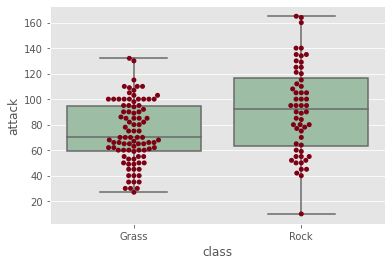

In [ ]:
# Визуализация
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'class', 'attack']
df_melt = df_melt[df_melt['attack'].notna()]
names = list(df_melt['class'])
ax = sns.boxplot(x='class', y='attack', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="class", y="attack", data=df_melt, color='#7d0013')
plt.show()

Визуально сила атаки у Grass не больше, а меньше, чем у Rock. Но гипотеза Оука звучит как " сила атаки Grass > Rock". Проверим ее

In [ ]:
# проверяем равенство дисперсий у Grass и Rock. Они вышли разные
fisher_test(data) 

Нулевая гипотеза: Grass=Rock
Альтернативная гипотеза: !(Grass=Rock)
Результат:
отклоняем нулевую гипотезу
p_value = 0.00027333381459902556,  f-значение = 13.908853861099338


In [ ]:
stat, p = st.ttest_ind(grass, rock, equal_var = False, alternative = 'less')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - сила атаки Grass = Rock')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную - сила атаки Grass < Rock')

Статистика=-3.41694, p=0.00048
Отклоняем нулевую гипотезу И принимаем альтернативную - сила атаки Grass < Rock


Вывод: Профессор Оук ошибся, сила атаки Grass < Rock

### Задача 2

Профессор Оук уже долго не может спать по ночам ведь его волнует вопрос, а правда, что покемоны что покемоны в классе `Water` в среднем более быстрые, чем покемоны в классе `Normal`. 
    
    
Проверьте, прав ли он, и убедите его в своем выводе статистически.
    
Примечание: если есть покемоны относятся к обоим классам, выбросьте их;
    
Вы можете предположить, что распределение скорости движения является нормальным для всех классов покемонов.


In [ ]:
# Удаляем строки, где у покемона одновременно и Water, и Normal
to_drop = pokemon.loc[((pokemon['Class 1']=='Water')&(pokemon['Class 2'] == 'Normal'))|((pokemon['Class 2']=='Water')&(pokemon['Class 1'] == 'Normal'))]
pokemon.drop(to_drop.index, inplace = True)

In [ ]:
# Формируем отдельные выборки grass и rock
water = pokemon.loc[(pokemon['Class 1']=='Water')|(pokemon['Class 2']=='Water')]['Speed'].tolist()
normal = pokemon.loc[(pokemon['Class 1']=='Normal')|(pokemon['Class 2']=='Normal')]['Speed'].tolist()

In [ ]:
# посчитаем средние значения силы атаки для Grass и Rock
data_dict = {'Water' : water, 'Normal' : normal}
data = pd.DataFrame.from_dict(data_dict,orient='index').T
data.mean()

Water     64.936000
Normal    72.257426
dtype: float64

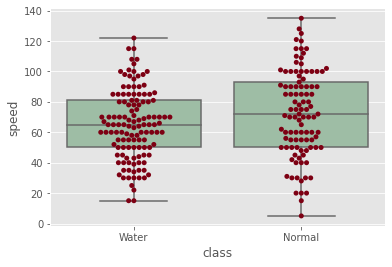

In [ ]:
# Визуализация
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'class', 'speed']
df_melt = df_melt[df_melt['speed'].notna()]
names = list(df_melt['class'])
ax = sns.boxplot(x='class', y='speed', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="class", y="speed", data=df_melt, color='#7d0013')
plt.show()

Визуально скорость у Water не больше, а меньше, чем у Normal. Но гипотеза Оука звучит как " скорость Water > Normal". Проверим ее

In [ ]:
# проверяем равенство дисперсий у Grass и Rock. Они вышли разные
fisher_test(data) 

Нулевая гипотеза: Water=Normal
Альтернативная гипотеза: !(Water=Normal)
Результат:
отклоняем нулевую гипотезу
p_value = 0.03255353551391051,  f-значение = 4.6264281532023235


In [ ]:
stat, p = st.ttest_ind(water, normal, equal_var = False, alternative = 'less')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - скорость Water = Normal')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную -  скорость Water < Normal')

Статистика=-2.10119, p=0.01847
Отклоняем нулевую гипотезу И принимаем альтернативную -  скорость Water < Normal


Вывод: Профессор Оук ошибся,  скорость Water < Normal

### Задача 3

Профессор Оук тот еще безумец. Он изобрел сыворотку, способную ускорить покемона. Однако, мы усомнились в эффективности его вакцины. Професоор дал эту сыворотку следующим покемонам: смотри массив `treathed_pokemon`. Проверьте, работает ли вообще его сыворотка, убедите всех в своем выводе статистически.
    
    
Вы можете предположить, что распределение скорости движения является нормальным для всех классов покемонов.

In [ ]:
# Покемоны, которые принимали сыворотку увеличения скорости
treathed_pokemon = ['Mega Beedrill', 'Mega Alakazam',
                    'Deoxys Normal Forme', 'Mega Lopunny']

In [ ]:
# Покемоны, которые не принимали сыворотку увеличения скорости
untreathed_pokemon = list (list(set(pokemon.Name.tolist()) - set(treathed_pokemon)))

In [ ]:
# Формируем отдельные выборки treathed_pokemon и untreathed_pokemon
treathed = pokemon[pokemon['Name'].isin(treathed_pokemon)]['Speed'].tolist()
untreathed = pokemon[pokemon['Name'].isin(untreathed_pokemon)]['Speed'].tolist()

In [ ]:
# посчитаем средние значения скорости для treathed и untreathed
data_dict = {'treathed' : treathed, 'untreathed' : untreathed}
data = pd.DataFrame.from_dict(data_dict,orient='index').T
data.mean()

treathed      145.00000
untreathed     67.97604
dtype: float64

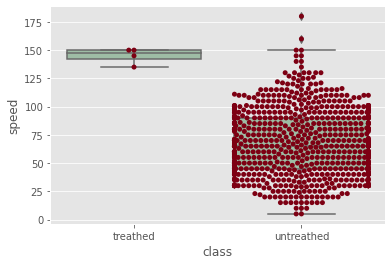

In [ ]:
# Визуализация
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'class', 'speed']
df_melt = df_melt[df_melt['speed'].notna()]
names = list(df_melt['class'])
ax = sns.boxplot(x='class', y='speed', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="class", y="speed", data=df_melt, color='#7d0013')
plt.show()

Визуально скорость у treathed больше чем у untreathed. Гипотеза Оука -такая же. Проверим ее статистически

In [ ]:
# проверяем равенство дисперсий у treathed и untreathed
fisher_test(data) 

Нулевая гипотеза: treathed=untreathed
Альтернативная гипотеза: !(treathed=untreathed)
Результат:
отклоняем нулевую гипотезу
p_value = 9.787942247267907e-08,  f-значение = 28.947882996499924


In [ ]:
stat, p = st.ttest_ind(treathed, untreathed, equal_var = False, alternative = 'greater')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - скорость treathed = untreathed')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную -  скорость treathed > untreathed')

Статистика=20.93828, p=0.00004
Отклоняем нулевую гипотезу И принимаем альтернативную -  скорость treathed > untreathed


Вывод: Профессор Оук не ошибся,  скорость treathed > untreathed 

### Задача 4

Профессор Оук всегда любил истории про легендарных покемонов. Однако, профессор не очень уверен, что они самые лучшие относительно остальных покемонов. Оук предложил разобраться в этом нам. Проверьте, действительно ли сумма характеристик `HP`,`Attack`,`Defense` у легендарных покемонов выше, чем у других покемонов? А произведение этих же параметров?? Найдите ответы на эти вопросы и убедите всех в своем выводе статистически.
   

Вы можете предположить, что распределение сум и произведений этих параметров является нормальным для всех классов покемонов.

In [ ]:
# Формируем отдельные выборки legendary и usual
legendary = pokemon.loc[pokemon['Legendary'] == True]
usual = pokemon.loc[pokemon['Legendary'] == False]

In [ ]:
# считаем для них отдельные столбцы суммы и произведения
pd.options.mode.chained_assignment = None 
legendary['summa'] = legendary[['HP','Attack', 'Defense']].sum(axis = 1)
legendary['power'] = legendary['HP'] * legendary['Attack'] * legendary['Defense']
usual['summa'] = usual[['HP','Attack', 'Defense']].sum(axis = 1)
usual['power'] = usual['HP'] * usual['Attack'] * usual['Defense']

In [ ]:
# посчитаем средние значения  для summa и power у legendary
legendary.loc[:,['summa', 'power']].mean()

summa    3.090769e+02
power    1.085942e+06
dtype: float64

In [ ]:
# посчитаем средние значения  для summa и power у usual
usual.loc[:,['summa', 'power']].mean()

summa       214.371585
power    425025.214481
dtype: float64

In [ ]:
legendary_sum = legendary['summa'].tolist()
usual_sum = usual['summa'].tolist()
data_dict ={'legendary': legendary_sum, 'usual': usual_sum}
data = pd.DataFrame.from_dict(data_dict,orient='index').T
data.mean()

legendary    309.076923
usual        214.371585
dtype: float64

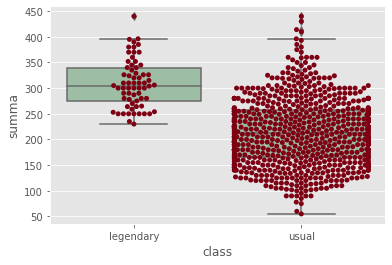

In [ ]:
# Визуализация
import warnings
warnings.filterwarnings('ignore')
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'class', 'summa']
df_melt = df_melt[df_melt['summa'].notna()]
names = list(df_melt['class'])
ax = sns.boxplot(x='class', y='summa', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="class", y="summa", data=df_melt, color='#7d0013')
plt.show()

Визуально summa у legendary выше, чем у usual. Проверим статистически

In [ ]:
# проверяем равенство дисперсий у legendary и usual. Они вышли разные
fisher_test(data) 

Нулевая гипотеза: legendary=usual
Альтернативная гипотеза: !(legendary=usual)
Результат:
отклоняем нулевую гипотезу
p_value = 9.199725638922485e-29,  f-значение = 134.0791366832536


In [ ]:
stat, p = st.ttest_ind(legendary_sum, usual_sum, equal_var = False, alternative = 'greater')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - сумма Legendary= usual')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную -  сумма Legendary> usual')

Статистика=15.19610, p=0.00000
Отклоняем нулевую гипотезу И принимаем альтернативную -  сумма Legendary> usual


Вывод: Профессор Оук не ошибся,  сумма показателей у  Legendary > чем у обычных покемонов

In [ ]:
legendary_power = legendary['power'].tolist()
usual_power = usual['power'].tolist()
data_dict ={'legendary': legendary_power, 'usual': usual_power}
data = pd.DataFrame.from_dict(data_dict,orient='index').T
data.mean()

legendary    1.085942e+06
usual        4.250252e+05
dtype: float64

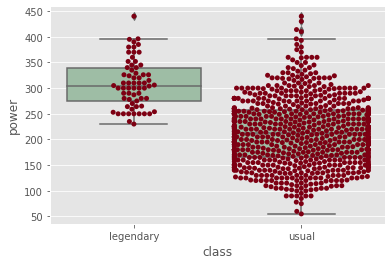

In [ ]:
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'class', 'power']
df_melt = df_melt[df_melt['power'].notna()]
names = list(df_melt['class'])
ax = sns.boxplot(x='class', y='power', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="class", y="power", data=df_melt, color='#7d0013')
plt.show()

Визуально power у legendary выше, чем у usual. Проверим статистически

In [ ]:
# проверяем равенство дисперсий у Grass и Rock. Они вышли разные
fisher_test(data) 

Нулевая гипотеза: legendary=usual
Альтернативная гипотеза: !(legendary=usual)
Результат:
отклоняем нулевую гипотезу
p_value = 2.568519069026579e-36,  f-значение = 175.3662242141361


In [ ]:
stat, p = st.ttest_ind(legendary_power, usual_power, equal_var = False, alternative = 'greater')
print('Статистика=%.5f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Не отклоняем нулевую гипотезу - power у  legendary = usual')
else:
    print('Отклоняем нулевую гипотезу И принимаем альтернативную - power у  legendary > usual')

Статистика=10.07776, p=0.00000
Отклоняем нулевую гипотезу И принимаем альтернативную - power у  legendary > usual


Вывод: Профессор Оук не ошибся, произведение характеристик у Legendary > чем у обычных покемонов

### Задача 5

Профессор Оук частенько наблюдает за боями покемонов. После очередных таких боев Оук выделил три класса `best_defence_class`, которые на его взгляд одинаковы по "силе обычной защиты" `Defense`. Проверьте, действительно ли эти классы покемонов не отличаются по уровню защиты статистически значимо? Все та же статистика вам в помощь! 
   

Вы можете предположить, что распределение сум и произведений этих параметров является нормальным для всех классов покемонов.

In [ ]:
best_defence_class = ['Rock', 'Ground', 'Steel', 'Ice']
best_defence_class

['Rock', 'Ground', 'Steel', 'Ice']

In [ ]:
# проверяем, нет ли у нас покемонов, у которых оба класса относятся к best_defence_class. Если есть - удаляем
to_drop = pokemon[(pokemon['Class 1'].isin(best_defence_class)) & (pokemon['Class 2'].isin(best_defence_class))]
to_drop

In [ ]:
# Формируем отдельные выборки rock, ground, steel, ice

rock = pokemon[(pokemon['Class 1']=='Rock') | (pokemon['Class 2']== 'Rock')]['Defense'].tolist()
ground = pokemon[(pokemon['Class 1']=='Ground') | (pokemon['Class 2']== 'Ground')]['Defense'].tolist()
steel = pokemon[(pokemon['Class 1']=='Steel') | (pokemon['Class 2']== 'Steel')]['Defense'].tolist()
ice = pokemon[(pokemon['Class 1']=='Ice') | (pokemon['Class 2']== 'Ice')]['Defense'].tolist()

In [ ]:
# посчитаем средние значения защиты для rock, ground, steel, ice
data_dict = {'rock' : rock, 'ground' : ground, 'steel' : steel, 'ice' : ice}
data = pd.DataFrame.from_dict(data_dict,orient='index').T
data.mean()

rock      107.803571
ground     87.701493
steel     116.612245
ice        76.657895
dtype: float64

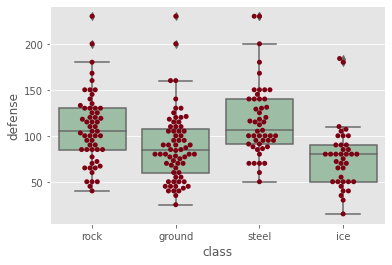

In [ ]:
# Визуализация
df_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars = list(data_dict.keys()))
df_melt.columns = ['index', 'class', 'defense']
df_melt = df_melt[df_melt['defense'].notna()]
names = list(df_melt['class'])
ax = sns.boxplot(x='class', y='defense', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="class", y="defense", data=df_melt, color='#7d0013')
plt.show()

из расчета средних значений и визуализации видно, что средния значения defense у классов Rock, Ground, Steel, Ice различаются. Проверим, насколько это статистически значимо

In [ ]:
fvalue, pvalue = st.f_oneway(rock, ground, steel, ice)

print('Статистика=%.3f, p=%.6f' % (fvalue, pvalue))
if pvalue > 0.05:
    print('Не отклоняем нулевую гипотезу, средние, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, средние, вероятно, различаются')

Статистика=10.895, p=0.000001
Отклоняем нулевую гипотезу, средние, вероятно, различаются


Таким образом, гипотеза о том, что классы Rock, Ground, Steel, Ice равны по уровню Defense, статистически не подтвердилась и была отвергнута Можно поисследовать, какие именно классы равны между собой

In [ ]:
names = [];
for k1 in list(data_dict.keys()):
    for k2 in range(len(data[data[k1].notna()][k1])):
        names.append(k1)

In [ ]:
tukey = pairwise_tukeyhsd(endog=pd.concat([data[data['rock'].notna()]['rock'], data[data['ground'].notna()]['ground'],data[data['steel'].notna()]['steel'],data[data['ice'].notna()]['ice']]).values,
                          groups=names,
                          alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
ground    ice -11.0436 0.4781  -30.941  8.8538  False
ground   rock  20.1021 0.0193   2.3621  37.842   True
ground  steel  28.9108  0.001  10.4935  47.328   True
   ice   rock  31.1457  0.001  10.5532 51.7382   True
   ice  steel  39.9544  0.001  18.7756 61.1331   True
  rock  steel   8.8087 0.6178 -10.3574 27.9748  False
-----------------------------------------------------


Как видно из Теста pairwise_tukeyhsd, по уровню Defense равны между собой попарно Классы Rock и Steel, а также Ground и Ice

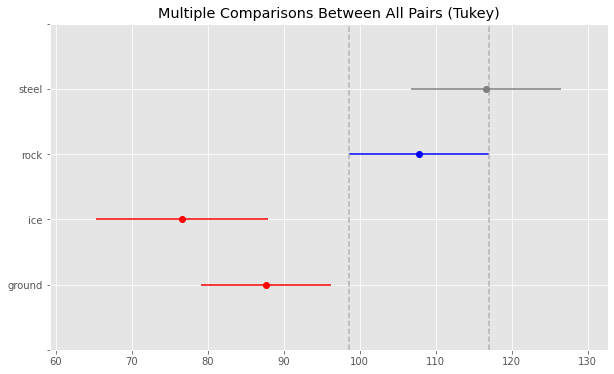

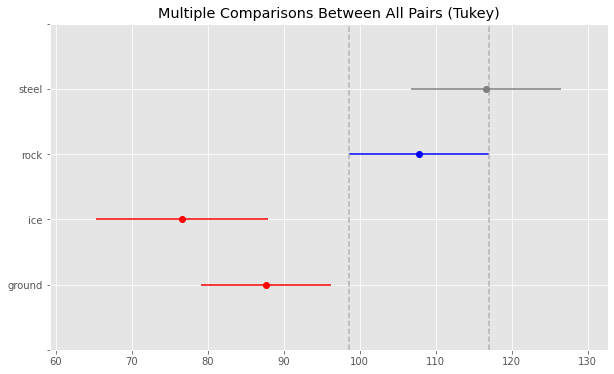

In [ ]:
tukey.plot_simultaneous(comparison_name="rock")